In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib.colors import LogNorm
import pywrapfst as of
from collections import defaultdict
from joblib import Parallel, delayed
from math import sqrt

def parsefn(x):
    return tuple([int(x.split('_')[1]) for x in Path(x).stem[5:].split('-')])

sns.set_context('talk')

In [2]:
dfinfo = pd.read_csv("../data/fsadb_uw_info.csv",index_col=0)
dfinfo.index = list(map(lambda x:str(Path(x).with_suffix(".fst")), dfinfo.index))
# dfinfo = dfinfo.drop(['labels_min_arcs', 'labels_max_arcs', 'n_labels_pairs', 
#         'states_min_arcs', 'states_max_arcs', 'n_states_pairs',
#         'max_out_degree'],axis=1)

In [3]:
# def get_arcs_info(x):
#     dl = defaultdict(lambda: 0)
#     ds = defaultdict(lambda: 0)
#     dli = defaultdict(lambda: 0)
#     dlo = defaultdict(lambda: 0)
#     max_dregree = 0
#     for s in range(x.num_states()):
#         c=0 
#         for a in x.arcs(s):
#             dl[(a.ilabel,a.olabel)]+=1
#             dli[a.ilabel]+=1
#             dlo[a.olabel]+=1
#             ds[(s,a.nextstate)]+=1
#             c+=1
#         max_dregree = max(c, max_dregree)
        

#     vals = dl.values()
#     if len(vals)>0:      
#         return min(dl.values()), max(dl.values()), len(dl.keys()), \
#                min(ds.values()), max(ds.values()), len(ds.keys()), \
#                max_dregree, max(dli.values()), max(dlo.values())
#     else:
#         return tuple([np.nan]*9)
        
# def read_and_act(path, fn):
#     return fn(of.Fst.read(path))

# res = Parallel(n_jobs=4)(delayed(
# lambda x: read_and_act(str(Path('../data/',x).with_suffix('.fst')), get_arcs_info)
# )(p) for p in dfinfo.index)

# dfinfo[['labels_min_arcs', 'labels_max_arcs', 'n_labels_pairs', 
#         'states_min_arcs', 'states_max_arcs', 'n_states_pairs',
#         'max_out_degree', 'max_degree_ilabel', 'max_degree_olabel']] = np.array(res)
# dfinfo.to_csv('../data/fsadb_uw_info.csv')

In [4]:
dfinfo['max_degree_iolabel'] = np.vstack([dfinfo['max_degree_ilabel'], dfinfo['max_degree_ilabel']]).max(0)

In [73]:
dfbench_ = pd.concat([
#            pd.read_csv("../results/fsadb_uw1_TensorFSTs_compbenchs.csv"),
           pd.read_csv("../results/fsadb_uw_TensorFSTs_onlycomp_compbenchs.csv"),
           pd.read_csv("../results/fsadb_uw_FiberTensorFSTs_compbenchs.csv"),
#            pd.read_csv("../results/fsadb_uw_CooOfCooSod_compbenchs.csv"),
#            pd.read_csv("../results/fsadb_uw_CooOfCooLod_compbenchs.csv"),
#            pd.read_csv("../results/fsadb_uw_CooOfCooMTLod_compbenchs.csv"),
#            pd.read_csv("../results/fsadb_uw_CscOfCooLod_compbenchs.csv"),
           pd.read_csv("../results/fsadb_uw_OpenFst_compbenchs.csv") 
          ])
dfbenchk2 = pd.read_csv("../results/fsadb_uw_k2_nosort_cpu_1_compbenchs.csv")
dfbenchk2 = dfbenchk2[~dfbenchk2['fileC'].isna()]
dfbenchk2["name"]="k2"
dfbenchk2[["min","max","mean","std"]] = dfbenchk2[["min","max","mean","std"]]*1e9

dfbenchk2cuda = pd.read_csv("../results/fsadb_uw_k2_nosort_cuda_8_compbenchs.csv")
dfbenchk2cuda["name"]="k2cuda"
dfbenchk2cuda[["min","max","mean","std"]] = dfbenchk2cuda[["min","max","mean","std"]]*1e9

In [74]:
# systems = ["OpenFst", "CooOfCoo", "CooOfCooMT", "CscOfCoo", "TensorFSTs", "k2"]
systems = ['CooOfCooLod','CooOfCooSod','CooOfCooMTLod','CscOfCooLod','OpenFst','TensorFSTs','TensorFSTs_onlycomp','k2','k2cuda']

In [75]:
dfbench = pd.concat([dfbench_, dfbenchk2, dfbenchk2cuda])

dfbench['fileA'] = dfbench['fileA'].map(lambda x: x[5:])
dfbench['fileB'] = dfbench['fileB'].map(lambda x: x[5:])

dfbench = dfbench.join(dfinfo, on="fileA", how="inner").join(dfinfo, on="fileB", how="inner", lsuffix="_A", rsuffix="_B")

dfbench['specsA'] = dfbench['fileA'].map(parsefn)
dfbench['specsB'] = dfbench['fileB'].map(parsefn)
dfbench = pd.concat([dfbench,dfbench['specsA'].apply(pd.Series).rename(columns={0:"nstatesA", 1:"narcsA", 2:"nsymsA", 3:"seedA"})],axis=1)
dfbench = pd.concat([dfbench,dfbench['specsB'].apply(pd.Series).rename(columns={0:"nstatesB", 1:"narcsB", 2:"nsymsB", 3:"seedB"})],axis=1)
dfbench['minimum_time_seconds'] = dfbench['min']/1e9
dfbench['mean_time_seconds'] = dfbench['mean']/1e9
dfbench = dfbench.rename(columns = {'nstates':'nstatesC','narcs':'narcsC'})

In [76]:
dfbench["sparsityA"]=1-dfbench["narcsA"]/(dfbench['nstatesA']**2*dfbench['nsymsA'])
# dfs["lognarcsA"]=np.log10(dfs["narcsA"])
# dfs["lognstatesA"]=np.log10(dfs["nstatesA"])
# dfs["lognsymsA"]=np.log10(dfs["nsymsA"])
dfbench["sparsityB"]=1-dfbench["narcsB"]/(dfbench['nstatesB']**2*dfbench['nsymsB'])
# dfs["lognarcsB"]=np.log10(dfs["narcsB"])
# dfs["lognstatesB"]=np.log10(dfs["nstatesB"])
# dfs["lognsymsB"]=np.log10(dfs["nsymsB"])

dfbench["prodnstates"]=dfbench["nstatesB"]*dfbench["nstatesA"]
dfbench["avgnstates"]=(dfbench["nstatesB"]+dfbench["nstatesA"])/2

dfbench["prodnarcs"]=dfbench["narcsB"]*dfbench["narcsA"]
dfbench["avgnarcs"]=(dfbench["narcsB"]+dfbench["narcsA"])/2

dfbench["avgnsyms"]=(dfbench["nsymsB"]+dfbench["nsymsA"])/2
# dfs["avgsparsity"]=(dfs["sparsityA"]+dfs["sparsityB"])/2
dfbench["minnsyms"] = np.vstack([dfbench['nsymsA'], dfbench['nsymsB']]).min(0)

In [77]:
dfbench['Otf'] = dfbench['minnsyms']*dfbench['max_degree_olabel_A']*dfbench['max_degree_ilabel_B']
dfbench['Otf2'] = dfbench['narcsA']*dfbench['narcsB']
dfbench['Otf4'] = dfbench['narcsA']*dfbench['narcsB']
dfbench['Otf3'] = dfbench['minnsyms']*dfbench['narcsA']*dfbench['narcsB']
dfbench['Osod'] = dfbench['n_states_pairs_A']*dfbench['n_states_pairs_B']*dfbench['max_out_degree_A']*dfbench['nsymsB']
dfbench['Oof'] = dfbench['nstatesC']*dfbench['max_out_degree_A']*np.log10(dfbench['max_out_degree_B'])+dfbench['narcsC']
dfbench['Olod'] = dfbench['labels_max_arcs_A']*dfbench['labels_max_arcs_B']*dfbench['n_labels_pairs_A']*dfbench['nsymsB']

In [78]:
# dfbench = dfbench[(dfbench['seedA']<1000) & (dfbench['seedB']<1000)]

In [79]:
dfbench['name'].unique()

array(['TensorFSTs_onlycomp', 'FiberTensorFSTs', 'OpenFst', 'k2',
       'k2cuda'], dtype=object)

In [20]:
# dfy = pd.pivot_table(dfbench, "minimum_time_seconds", "fileC", "name")
# dfy = pd.concat([dfy, dfbench[dfbench["name"]=="OpenFst"].set_index("fileC")],axis=1)
# crr = dfy.corr(numeric_only=True)
# for s in systems:
#     display(s, crr.drop(systems+['min','mean','max','std','mean_time_seconds','minimum_time_seconds'],axis=0)[s].sort_values(ascending=False).iloc[:7])

In [ ]:
# pd.read_csv('../data/fsadb_uw_composed.csv').iloc[265:267]

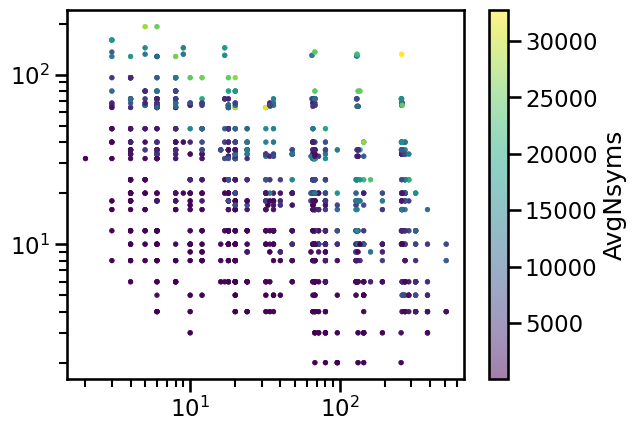

In [48]:
plt.scatter(dfbench['avgnsyms'], dfbench['avgnstates'], s=5,alpha=0.5, c= dfbench['avgnarcs'])
plt.colorbar(label='AvgNsyms');
plt.yscale('log')
plt.xscale('log')
# plt.xlabel('OpenFst Complexity')
# plt.ylabel('Sod Complexity')

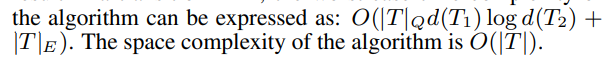

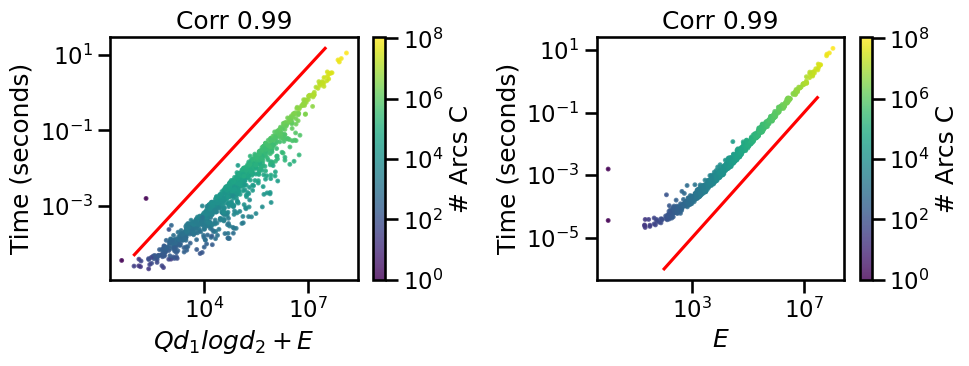

In [49]:
dfx = dfbench[dfbench['name']=='OpenFst']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
c = np.corrcoef(dfx['minimum_time_seconds'],dfx['Oof'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['Oof'] , dfx['minimum_time_seconds'],s=4,c=dfx['narcsC'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# Arcs C');
plt.yscale('log')
plt.xscale('log')

plt.plot([1e2,3e7],5e-7*np.array([1e2,3e7]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$Q d_1 log{d_2} + E$');

plt.subplot(1,2,2)

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsC'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['narcsC'] , dfx['minimum_time_seconds'],s=4,c=dfx['narcsC'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# Arcs C');
plt.yscale('log')
plt.xscale('log')

plt.plot([1e2,3e7],1e-8*np.array([1e2,3e7]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$E$');

plt.tight_layout()

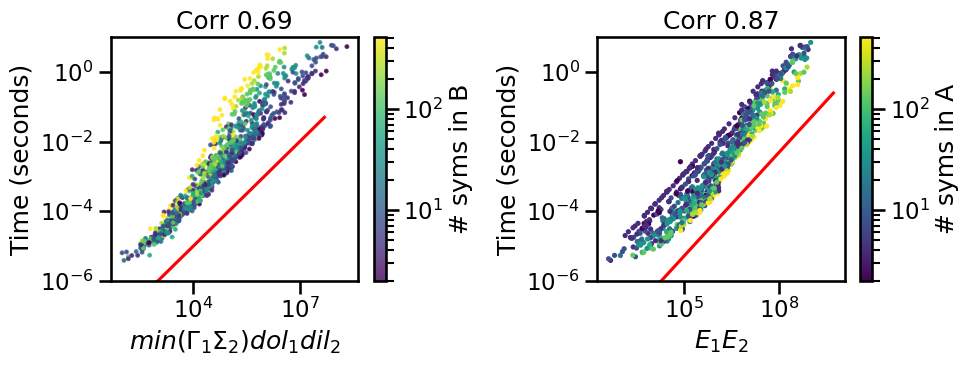

In [50]:
dfx = dfbench[dfbench['name']=='TensorFSTs_onlycomp']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
c = np.corrcoef(dfx['minimum_time_seconds'],dfx['Otf'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['Otf'] , dfx['minimum_time_seconds'],s=4,c=dfx['nsymsB'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# syms in B');
plt.yscale('log')
plt.xscale('log')

plt.plot([3e2,5e7],1e-9*np.array([3e2,5e7]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$min(\Gamma_1 \Sigma_2) dol_1 dil_2$');
plt.ylim(1e-6,1e1)
plt.subplot(1,2,2)

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsA']*dfx['narcsB'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['narcsA']*dfx['narcsB'] , dfx['minimum_time_seconds'] , s=5, c=dfx['nsymsA'], norm=LogNorm())
plt.colorbar(label='# syms in A')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('$E_1 E_2$');
plt.plot([3e3,5e9],0.5e-10*np.array([3e3,5e9]),'r')
plt.ylim(1e-6,1e1)
plt.tight_layout()

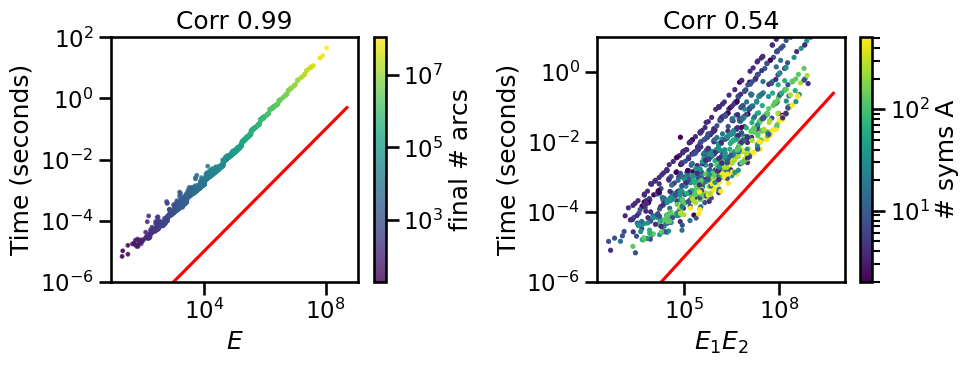

In [95]:
dfx = dfbench[dfbench['name']=='FiberTensorFSTs']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
x = dfx['narcsC']
c = np.corrcoef(dfx['minimum_time_seconds'],x)[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(x , dfx['minimum_time_seconds'],s=4,c=dfx['narcsC'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='final # arcs');
plt.yscale('log')
plt.xscale('log')

plt.plot([3e2,5e8],1e-9*np.array([3e2,5e8]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$E$');
plt.ylim(1e-6,1e2)
plt.subplot(1,2,2)

x = dfx['minnsyms']*dfx['max_degree_olabel_A']*dfx['max_degree_ilabel_B']
x = dfx['narcsA']*(dfx['narcsB'])

c = np.corrcoef(dfx['minimum_time_seconds'],x)[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(x , dfx['minimum_time_seconds'] , s=5, c=dfx['nsymsA'], norm=LogNorm())
plt.colorbar(label='# syms A')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('$E_1 E_2$');
plt.plot([3e3,5e9],0.5e-10*np.array([3e3,5e9]),'r')
plt.ylim(1e-6,1e1)
plt.tight_layout()

/tmp/ipykernel_379888/713275470.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


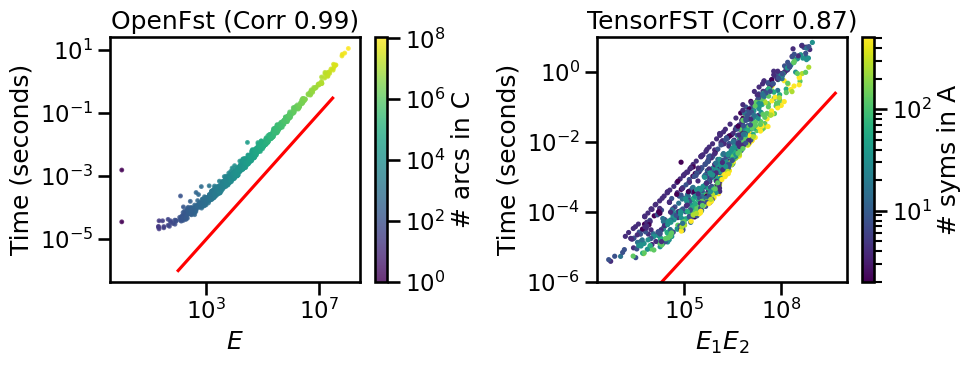

In [51]:
dfx = dfbench[dfbench['name']=='OpenFst']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsC'])[0,1]
plt.title(f"OpenFst (Corr {c:0.2})")
plt.scatter(dfx['narcsC'] , dfx['minimum_time_seconds'],s=4,c=dfx['narcsC'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# arcs in C');
plt.yscale('log')
plt.xscale('log')

plt.plot([1e2,3e7],1e-8*np.array([1e2,3e7]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$E$');

plt.subplot(1,2,2)

dfx = dfbench[dfbench['name']=='TensorFSTs_onlycomp']

plt.tight_layout()

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsA']*dfx['narcsB'])[0,1]
plt.title(f"TensorFST (Corr {c:0.2})")
plt.scatter(dfx['narcsA']*dfx['narcsB'] , dfx['minimum_time_seconds'] , s=5, c=dfx['nsymsA'], norm=LogNorm())
plt.colorbar(label='# syms in A')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('$E_1 E_2$');
plt.plot([3e3,5e9],0.5e-10*np.array([3e3,5e9]),'r')
plt.ylim(1e-6,1e1)

plt.tight_layout()

In [ ]:
dfx = dfbench[dfbench['name']=='OpenFst']
plt.scatter(dfx['narcsA']*dfx['narcsB'] , dfx['narcsC'] , s=5, c=dfx['nsymsB']*dfx['nsymsA'], norm=LogNorm())
plt.plot([3e3,0.5e9],np.array([3e3,0.5e9]),'r')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# dfx = dfbench[dfbench['name']=='OpenFst']
# plt.scatter(dfx['Olod'] , dfx['minimum_time_seconds'] , s=5)
# plt.yscale('log')
# plt.xscale'log')

In [ ]:
dfx = dfbench[dfbench['name']=='CscOfCooLod']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
c = np.corrcoef(dfx['minimum_time_seconds'],dfx['Olod'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['Olod'], dfx['minimum_time_seconds'],s=4,c=dfx['narcsC'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# syms in B');
plt.yscale('log')
plt.xscale('log')

plt.plot([3e3,5e7],1e-7*np.array([3e3,5e7]),'r')
plt.ylabel('Time (seconds)')
plt.xlabel('$ g_1 g_2 \\rho_1 \Gamma_2 $');
plt.ylim(1e-6,1e1)
plt.subplot(1,2,2)

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsC']*dfx['narcsB'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['narcsC'] , dfx['minimum_time_seconds'] , s=5, c=dfx['minnsyms'], norm=LogNorm())
plt.colorbar(label='$min(\Gamma_1 \Sigma_2)$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('$E$');
plt.plot([1e3,1e8],1e-8*np.array([1e3,1e8]),'r')
plt.tight_layout()

In [ ]:
dfx = dfbench[dfbench['name']=='CooOfCooSod']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
c = np.corrcoef(dfx['minimum_time_seconds'],dfx['Otf'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['Osod'], dfx['minimum_time_seconds'],s=4,c=dfx['minnsyms'], alpha=0.8, norm=LogNorm())
plt.colorbar(label='# syms in B');
plt.yscale('log')
plt.xscale('log')

plt.plot([3e2,5e7],1e-9*np.array([3e2,5e7]),'r')
plt.ylabel('Time (seconds)')
# plt.xlabel('$min(\Gamma_1 \Sigma_2) dol_1 dil_2$');
plt.ylim(1e-6,1e1)
plt.subplot(1,2,2)

c = np.corrcoef(dfx['minimum_time_seconds'],dfx['narcsC']*dfx['narcsB'])[0,1]
plt.title(f"Corr {c:0.2}")
plt.scatter(dfx['narcsC'] , dfx['minimum_time_seconds'] , s=5, c=dfx['minnsyms'], norm=LogNorm())
plt.colorbar(label='$min(\Gamma_1 \Sigma_2)$')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Time (seconds)')
plt.xlabel('$E$');
plt.plot([1e3,1e8],1e-8*np.array([1e3,1e8]),'r')
plt.tight_layout()

In [ ]:
# dfx = dfbench[dfbench['name']=='TensorFSTs_onlycomp']
# plt.scatter(dfx['Otf'] , dfx['Otf2'] , s=5, c=dfx['avgnsyms'])
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
dfx[dfx['minimum_time_seconds'].between(0.01,0.02)].corr(numeric_only=True)['minimum_time_seconds'].sort_values(ascending=False).iloc[:10].plot.bar()

In [ ]:
# dfx = dfbench[dfbench['name']=='TensorFSTs']
# plt.scatter(dfx['Oof'] , dfx['minimum_time_seconds'] , s=5, c='r',alpha=0.2)

# dfx = dfbench[dfbench['name']=='CooOfCoo']
# plt.scatter(dfx['Oof'] , dfx['minimum_time_seconds'] , s=5, c='b',alpha=0.2)

# dfx = dfbench[dfbench['name']=='OpenFst']
# plt.scatter(dfx['Oof'] , dfx['minimum_time_seconds'] , s=5, c='g',alpha=0.2)
# plt.yscale('log')
# plt.xscale('log')

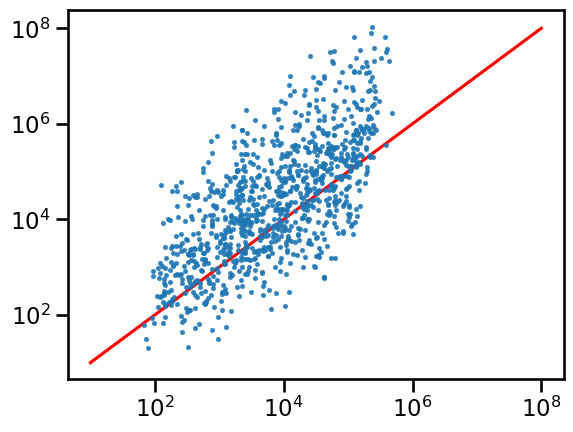

In [102]:
plt.plot([1e1,1e8],np.array([1e1,1e8]),'r',zorder=-2)
plt.scatter(dfx['narcsA']*np.log(dfx['narcsB']), dfx['narcsC'], s=5,alpha=0.8)
plt.yscale('log')
plt.xscale('log')
# plt.xlabel('OpenFst Complexity')
# plt.ylabel('Sod Complexity')

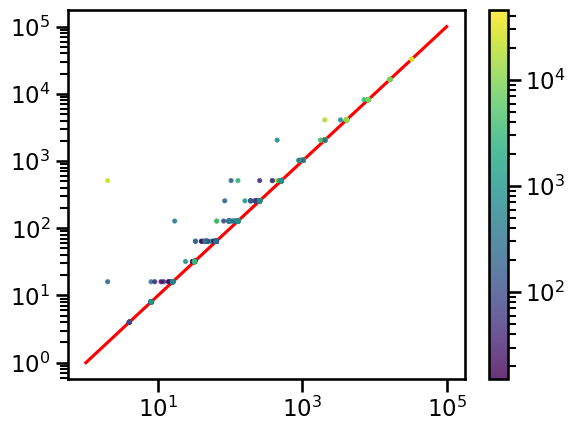

In [128]:
dfx = dfbench[dfbench['name']=='OpenFst']
x = dfx['nstatesC']

dfx = dfbench[dfbench['name']=='FiberTensorFSTs']
y = dfx['nstatesC']

plt.scatter(x,y, s=5, alpha=0.8, c = dfx['narcsB'], norm=LogNorm())
plt.yscale('log')
plt.xscale('log')
plt.plot([1e0,1e5],np.array([1e0,1e5]),'r', zorder=-1)

plt.colorbar()

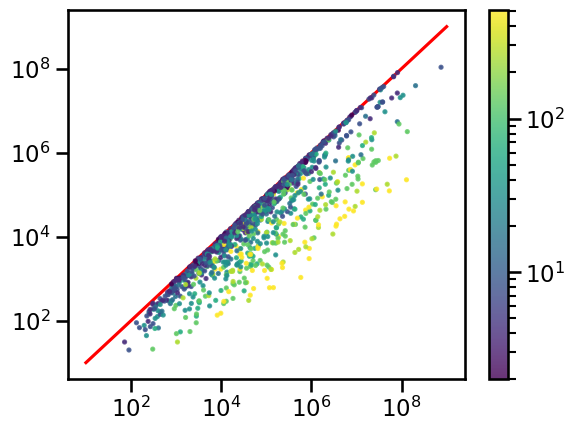

In [113]:
plt.plot([1e1,1e9],np.array([1e1,1e9]),'r',zorder=-2)
plt.scatter(dfx['narcsA']*dfx['labels_max_arcs_B'], dfx['narcsC'], s=5, c = dfx['nsymsA'] , alpha=0.8, norm=LogNorm())
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
# plt.ylabel('Sod Complexity')

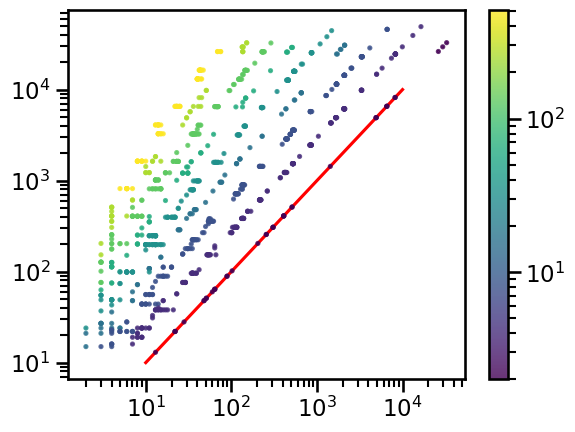

In [110]:
plt.plot([1e1,1e4],np.array([1e1,1e4]),'r',zorder=-2)
plt.scatter(dfx['labels_max_arcs_A'], dfx['narcsA'], s=5, c = dfx['nsymsA'] , alpha=0.8, norm=LogNorm())
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
# plt.ylabel('Sod Complexity')

Text(0, 0.5, 'Sod Complexity')

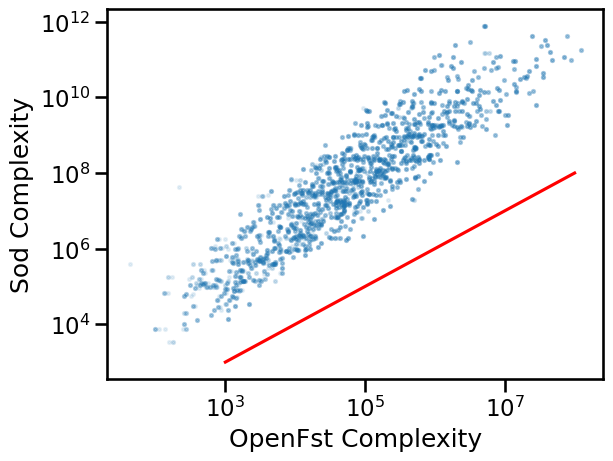

In [96]:
plt.scatter(dfbench['Oof'], dfbench['Osod'], s=5,alpha=0.1)
plt.plot([1e3,1e8],np.array([1e3,1e8]),'r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('OpenFst Complexity')
plt.ylabel('Sod Complexity')

In [ ]:
plt.scatter(dfbench['Oof'], dfbench['Olod'], s=5,alpha=0.1)
plt.plot([1e3,1e8],np.array([1e3,1e8]),'r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('OpenFst Complexity')
plt.ylabel('Lod Complexity')

In [ ]:
plt.scatter(dfbench['minnsyms']*dfbench['max_degree_olabel_A']*dfbench['max_degree_ilabel_B'],
            dfbench['narcsA']*dfbench['max_degree_ilabel_B'], s=5,alpha=0.1)
plt.plot([1e3,1e8],np.array([1e3,1e8]),'r')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.scatter(dfbench['Olod'], dfbench['Osod'], s=5,alpha=0.1)
plt.plot([1e3,1e8],np.array([1e3,1e8]),'r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Lod Complexity')
plt.ylabel('Sod Complexity');